In [1]:
from importlib import reload
import pandas as pd
import time
import text_preprocessing as wpp
import country_extractor as ce
import sentiment_analyser as sa
import topic_categorizer as tc
import entity_subject_extractor as ese

Reading raw data

In [ ]:
data = pd.read_csv('../data/new_data_vdss.tsv.xz', sep='\t', compression='xz')

Delete redundant columns

In [ ]:
data['date'] = data['pubtime'].str.extract(r'(\d{4}-\d{2}-\d{2})')
data['date'] = pd.to_datetime(data['date'])
del data['pubtime']
del data['medium_code']
del data['regional']
del data['doctype']
del data['language']
del data['char_count']
del data['dateline']
del data['subhead']
del data['content_id']
del data['id']
del data['rubric']
del data['doctype_description']

Text preprocessing for article content

In [ ]:
preprocessor = wpp.TextPreprocessing()

start_time = time.time()
data['content_processed'] = data['content'].apply(lambda x: preprocessor.preprocess_text(x) if isinstance(x, str) else [])
end_time = time.time()

elapsed_time = end_time - start_time

del data['content']

print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

Country extraction with runtime estimation

In [ ]:
extractor = ce.CountryExtractor()
%timeit extractor.get_country(data['content'][0])

68.1 µs ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

In [ ]:
extractor = ce.CountryExtractor()
data['countries'] = data['content_processed'].apply(lambda x: extractor.get_country(x) if isinstance(x[0], str) else [])

Sentiment analysis with runtime estimation

In [ ]:
reload(sa)
sentiment_analyser = sa.SentimentAnalyser()
%timeit sentiment_analyser.get_topic_sentiments_polarity(data['content_processed'][0])

12.8 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [ ]:
sentiment_analyser = sa.SentimentAnalyser()

start_time = time.time()
data['sentiment'] = data['content_processed'].apply(lambda x: sentiment_analyser.get_topic_sentiments_polarity(x))
end_time = time.time()

elapsed_time = end_time - start_time

print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

data.to_csv('../data/processed_data.tsv.xz', sep='\t', index=False, compression='xz')

Elapsed Time: 7932.10 seconds

Subjectivity analysis with runtime estimation

In [ ]:
reload(sa)
sentiment_analyser = sa.SentimentAnalyser()
%timeit sentiment_analyser.get_topic_subjectivity(data['content_processed'][0])

16.4 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [ ]:
sentiment_analyser = sa.SentimentAnalyser()

start_time = time.time()
data['subjectivity'] = data['content_processed'].apply(lambda x: sentiment_analyser.get_topic_subjectivity(x))
end_time = time.time()

elapsed_time = end_time - start_time

print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

data.to_csv('../data/processed_data2.tsv.xz', sep='\t', index=False, compression='xz')

Elapsed Time: 9175.09 seconds

Categorize content with runtime estimation

In [ ]:
reload(tc)
categorizer = tc.TopicCategorizer()
%timeit data['content_processed'][:1].apply(lambda x: categorizer.categorize(x))

14 ms ± 899 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [ ]:
categorizer = tc.TopicCategorizer()

start_time = time.time()
data['article_category'] = data['content_processed'].apply(lambda x: categorizer.categorize(x))
end_time = time.time()

elapsed_time = end_time - start_time

print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

data.to_csv('../data/processed_data5.tsv.xz', sep='\t', index=False, compression='xz')

Elapsed Time: 6759.97 seconds

Extracting entities runtime estimation

In [ ]:
reload(ese)
entity_extractor = ese.EntityAndSubjectExtractor()
%timeit processed_data['head'][:1].apply(lambda x: entity_extractor.extract_entities(x))

4.85 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [ ]:
entity_extractor = ese.EntityAndSubjectExtractor()

start_time = time.time()
data['entities_header'] = data['head'].apply(lambda x: entity_extractor.extract_entities(x))
end_time = time.time()

elapsed_time = end_time - start_time

print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

data.to_csv('../data/processed_data_final.tsv.xz', sep='\t', index=False, compression='xz')

Elapsed Time: 830.65 seconds

In [ ]:
translate_countries = ce.CountryExtractor()
data['countries_en'] = data['countries'].apply(lambda x: translate_countries.country_translation(x))

In [ ]:
data.to_csv('../data/processed_data_final.tsv.xz', sep='\t', index=False, compression='xz')

Import processed data, using eval to convert content_processed and countries to list

In [ ]:
processed_data = pd.read_csv('../data/processed_data_final.tsv.xz', sep='\t', compression='xz')
processed_data['content_processed'] = processed_data['content_processed'].apply(eval)
#proc_data['countries'] = proc_data['countries'].apply(eval)

In [ ]:
# Aufbereitung der Liste mit Persönlichkeiten

import re

names = []
with open("../data/persoenlichkeiten_raw.txt", 'r', encoding='UTF-8') as file:
    for line in file:
        names.append(re.sub(r'^\d+\.\s', '', line.strip()))

names = set(names)
names_df = pd.DataFrame(names)
names_df.to_csv("../data/persoenlichkeiten.csv")

In [ ]:
reload(ese)
people_extractor = ese.EntityAndSubjectExtractor()
start_time = time.time()
processed_data['people'] = processed_data['content_processed'].apply(people_extractor.extract_people)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

processed_data.to_csv('../data/processed_data_final_add_people.tsv.xz', sep='\t', index=False, compression='xz')

In [ ]:
del processed_data['content_processed']
processed_data.to_csv('../data/without_content.tsv.xz', sep='\t', index=False, compression='xz')

In [2]:
df = pd.read_csv('../data/without_content.tsv.xz', sep='\t', compression='xz')
df['countries'] = df['countries'].apply(eval)

In [4]:
df

,medium_name,head,date,countries,sentiment,subjectivity,entities_header,article_category,countries_en,people
0,blick.ch,Schweden beschliesst starke Leitzinserhöhung,2022-09-20,[Schweden],0.700000,0.000000,['Leitzinserhöhung'],Wirtschaft,['Sweden'],[]
1,srf.ch,Handball-Nati: Schweizerinnen unterliegen Pole...,2022-04-24,"[Ukraine, Slowenien, Polen, Schweiz, Russland]",-0.140000,0.000000,"['Schweizerinn', 'Quali-Ende']",Sport,"['Ukraine', 'Slovenia', 'Poland', 'Switzerland...",[]
2,swissinfo.ch,"""Wir befürchten, dass die Tabakinitiative die ...",2022-01-11,"[Frankreich, Italien, Schweiz]",0.150000,0.075000,"['Tabakinitiative', 'Tür', 'Werbeverbot']",Politik,"['France', 'Italy', 'Switzerland']",[]
3,NZZ am Sonntag,News,2022-08-28,[],0.000000,0.000000,['News'],Wissenschaft & Technik,[],[]
4,srf.ch,Wenn Wassersportler fliegen lernen,2022-08-15,"[USA, Australien, Schweiz]",0.194118,0.088235,['Wassersportler'],Sport,"['USA', 'Australia', 'Switzerland']",['Drake']
...,...,...,...,...,...,...,...,...,...,...
153195,Berner Zeitung,Warum Opfer von Online-Hetze oft machtlos sind,2022-11-24,"[USA, Irland, Schweiz]",-0.432558,0.134884,"['Opfer', 'Online-Hetze']",Politik,"['USA', 'Ireland', 'Switzerland']",[]
153196,20 minuten,Bürocontainer in Vollbrand,2022-02-07,[],-0.850000,0.000000,['Bürocontainer'],Regional,[],[]
153197,blick.ch,Bundespräsident Cassis zu Besuch in Wien,2022-01-13,"[Ukraine, USA, Schweiz, Österreich, Russland]",0.350000,0.000000,"['Bundespräsident', 'Besuch']",Politik,"['Ukraine', 'USA', 'Switzerland', 'Austria', '...",['Ignazio Cassis']
153198,NZZ am Sonntag,Classe politique,2022-02-13,[Niger],0.000000,0.000000,[],Politik,['Niger'],['Ignazio Cassis']


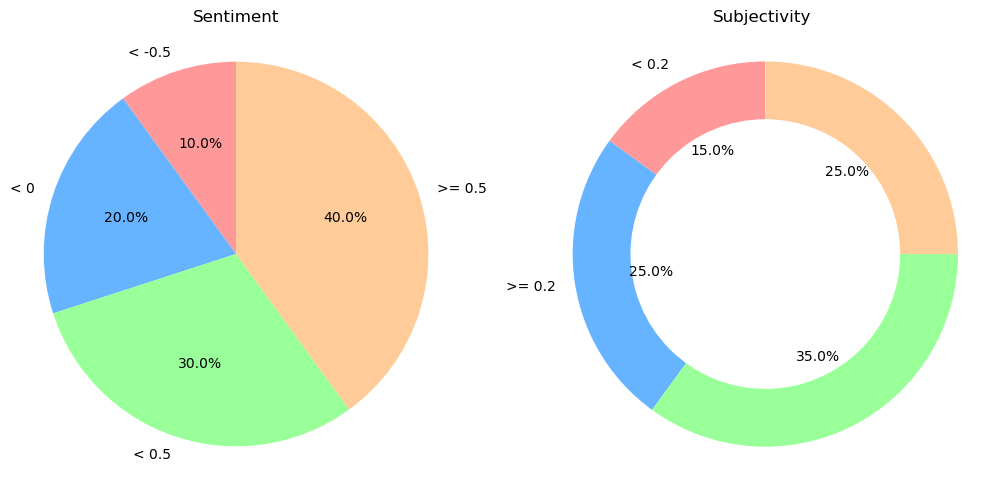

In [7]:
import matplotlib.pyplot as plt

# Erstellen Sie Daten zur Demonstration
sentiment_counts = [10, 20, 30, 40]
sentiment_labels = ['< -0.5', '< 0', '< 0.5', '>= 0.5']

subjectivity_counts = [15, 25, 35, 25]
subjectivity_labels = ['< 0.2', '>= 0.2', '', '']

# Erstellen Sie eine Farbpalette
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Erstellen Sie die Plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pie(sentiment_counts, labels=sentiment_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Sentiment')
# Erstellen Sie einen weißen Kreis in der Mitte
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

axs[1].pie(subjectivity_counts, labels=subjectivity_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Subjectivity')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Äquales Seitenverhältnis gewährleistet, dass der Kuchen kreisförmig gezogen wird
axs[0].axis('equal')  
axs[1].axis('equal')

plt.tight_layout()
plt.show()
